In [1]:
import numpy as np
import warnings
import pandas as pd
from typing import Tuple, Dict
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
EPSILON = 1e-8

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Q1 - *Forwards*

In [2]:
def initialize_parameters(layer_dims : np.ndarray) -> dict:
    parameters = {}     # This will hold the parameters

    # randomize the weights in each layer and set to zero all the biases
    for i in range (1,layer_dims.size):
        parameters[f"W{i}"] = np.array((np.random.randn(layer_dims[i],layer_dims[i-1])))*np.sqrt(2/layer_dims[i-1])
        parameters[f"b{i}"] = np.zeros((layer_dims[i],1))

    return parameters

In [3]:
def linear_forward(A : np.ndarray, W : np.ndarray, b : np.ndarray)->Tuple[np.ndarray, dict]:
    """
    This function gets as input activation vector A, weight matrix W and bias vector b for each layer
    The output will be vector Z and a dictionary that saves the inpt parameters
    """
    Z = np.dot(W,A) + b

    linear_cach = {"A" : A,
                 "W" : W,
                 "b" : b
                }
    return Z, linear_cach

In [4]:
def Softmax(Z : np.ndarray)->Tuple[np.ndarray, dict]:
    """
    This function gets as an input the Z vector
    The output will be the activation vector for this function using the softmax function and the Z input
    """
    # Z should be np.array
    Z_max = np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z - Z_max)
    exp_Z_sum = np.sum(exp_Z, axis=0, keepdims=True) + EPSILON
    A = exp_Z / exp_Z_sum
    activation_cache = {"Z": Z}
    return A, activation_cache

In [5]:
def ReLu(Z : np.ndarray)->Tuple[np.ndarray, dict]:
    """
    This function gets as an input the Z vector
    The output will be the activation vector for this function using the ReLu function and the Z input
    """

    relu_func = lambda Z : np.maximum(0,Z)
    A = relu_func(Z)
    activation_cache  = Z

    return A, activation_cache

In [6]:
def linear_activation_forward(A_prev : np.ndarray, W : np.ndarray, b : np.ndarray, activation : str) -> Tuple[np.ndarray , dict]:
    """
    This function inputs are the previous layer activation, its weight matrix and the activation function
    The output is the activation vector and activation cach and the dictionary saving the information
    """
    Z, linear_cach = linear_forward(A_prev, W, b)

    if activation == "softmax":
        A, activation_cache = Softmax(Z)
    elif activation == "relu":
        A, activation_cache = ReLu(Z)
    else:
        raise ValueError("The Activation code is not recognizable")

    dict_update = ({"Z" : activation_cache})
    cach = {**linear_cach,**dict_update}

    return A, cach

In [7]:
def L_model_forward(X : np.ndarray, parameters : dict, use_batchnorm : bool) -> Tuple[np.ndarray, dict]:
    """
    Function input:
    X - the data, numpy array of shape (input size, number of examples)
    parameters – the initialized W and b parameters of each layer - a dictionary with W_i and b_i as titles
    use_batchnorm - a boolean flag used to determine whether to apply batchnorm after the activation

    Funciton output:
    AL – the last post-activation value
    caches – a list of all the cache objects generated by the linear_forward function
    """
    # X = X.T
    # For the case the number of examples is one
    if(X.ndim == 1):
        X = X.reshape(-1,1)

    num_param = np.shape(X)[0] #number of lines
    num_examples = np.shape(X)[1] #number of columns
    caches = {}
    L = len(parameters) // 2  #number of layers
    A_prev = X
    for j in range(1,L):

        W = parameters[f'W{j}']
        b = parameters[f'b{j}']
        A_prev, cach = linear_activation_forward(A_prev, W, b,'relu')
        caches.update({f'Layer_{j}' : cach})

    W = parameters[f'W{L}']
    b = parameters[f'b{L}']
    # bias = np.array([b]*num_examples).T #creates a bias matrix
    AL, cach = linear_activation_forward(A_prev, W, b,'softmax')
    caches.update({f'Activation Layer' : cach})

    # print (f"Activation for last layer is {AL}")

    return AL, caches

In [8]:
def compute_cost(AL : np.ndarray,Y : np.ndarray)-> int:
    """
    Input:
    AL – probability vector corresponding to your label predictions, shape (num_of_classes, number of examples)
    Y – the labels vector (i.e. the ground truth)

    Output:
    cost – the cross-entropy cost
    """
    num_examples = np.shape(AL)[1]
    cost = -np.sum(np.dot(Y,np.log(AL.T + EPSILON)))
    return cost/num_examples

In [9]:
def apply_batchnorm(A : np.ndarray)-> int:
    """
    Description:
    performs batchnorm on the received activation values of a given layer.

    Input:
    A - the activation values of a given layer

    output:
    NA - the normalized activation values, based on the formula learned in class
    """
    mu = np.mean(A, axis=0)
    var = np.var(A, axis=0)
    A_normalized = (A - mu) / np.sqrt(var + EPSILON)

    return A_normalized

## Q2 - *Backwards*

In [10]:
def linear_backward(dZ : np.ndarray, cache : dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    description:
    Implements the linear part of the backward propagation process for a single layer

    Input:
    dZ – the gradient of the cost with respect to the linear output of the current layer (layer l)
    cache – tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Output:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache['A'], cache['W'], cache['b']
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db



In [11]:
def relu_backward(dA : np.ndarray, activation_cache : np.ndarray) -> np.ndarray:
    """
    Description:
    Implements backward propagation for a ReLU unit

    Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output:
    dZ – gradient of the cost with respect to Z
    """
    Z = activation_cache
    dZ = np.array(dA, copy=True)  # Converting dA to a correct object

    # When Z <= 0, set dZ to 0
    dZ[Z <= 0] = 0

    return dZ

In [40]:
def softmax_backward(dA : np.ndarray, activation_cache : dict) -> np.ndarray:
    """
    Description:
    Implements backward propagation for a softmax unit

    Input:
    dA – the post-activation gradient
    activation_cache – contains Z (stored during the forward propagation)

    Output:
    dZ – gradient of the cost with respect to Z
    """

    Z = activation_cache['Z']

    # Calculate softmax(Z)
    # Z_max = np.max(Z, axis=0, keepdims=True)
    # exp_Z = np.exp(Z - Z_max)
    # sum_expZ = np.sum(exp_Z, axis=0, keepdims=True) + EPSILON
    p,_ = Softmax(Z)
    # Calculate dZ=p-y (dA=y when using cross-entropy)
    dZ = p-dA

    return dZ

In [38]:
def linear_activation_backward(dA : np.ndarray, cache : dict, activation : str) -> Tuple[np.ndarray,np.ndarray,np.ndarray] :
    """
    Description:
    Implements the backward propagation for the LINEAR->ACTIVATION layer. The function first computes dZ and then applies the linear_backward function.

    Some comments:
        The derivative of ReLU is f^' (x)={■(1&if x>0@0&otherwise)┤
        The derivative of the softmax function is: p_i-y_i, where p_i is the softmax-adjusted probability of the class and y_i is the “ground truth” (i.e. 1 for the real class, 0 for all others)
        You should use the activations cache created earlier for the calculation of the activation derivative and the linear cache should be fed to the linear_backward function

    Input:
    dA – post activation gradient of the current layer
    cache – contains both the linear cache and the activations cache

    Output:
    dA_prev – Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW – Gradient of the cost with respect to W (current layer l), same shape as W
    db – Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache = {}
    linear_cache['A'] = cache['A']
    linear_cache['W'] = cache['W']
    linear_cache['b'] = cache['b']
    activation_cache = cache['Z']

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    else:
        raise ValueError("The Activation code is not recognizable")

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db


In [14]:
def L_model_backward(AL : np.ndarray, Y : np.ndarray, caches : dict) -> dict:
    """
    Description:
    Implement the backward propagation process for the entire network.

    Some comments:
    the backpropagation for the softmax function should be done only once as only the output layers uses it and the RELU should be done iteratively over all the remaining layers of the network.

    Input:
    AL - the probabilities vector, the output of the forward propagation (L_model_forward)
    Y - the true labels vector (the "ground truth" - true classifications)
    Caches - list of caches containing for each layer: a) the linear cache; b) the activation cache

    Output:
    Grads - a dictionary with the gradients
                grads["dA" + str(l)] = ...
                grads["dW" + str(l)] = ...
                grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    # Y = np.tile(Y,(m,1)).T  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    # Gradient of cost with respect to AL
    dAL = Y

    # Lth layer (softmax -> linear) gradients. Inputs: "AL, Y, caches".
    current_cache = caches[str(list(caches.keys())[-1])]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "softmax")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (ReLU -> linear) gradients.
        current_cache = caches[(list(caches.keys())[l])]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [15]:
def update_parameters(parameters : dict, grads : dict, learning_rate : int) -> dict:
    """
    Description:
    Updates parameters using gradient descent

    Input:
    parameters – a python dictionary containing the DNN architecture’s parameters
    grads – a python dictionary containing the gradients (generated by L_model_backward)
    learning_rate – the learning rate used to update the parameters (the “alpha”)

    Output:
    parameters – the updated values of the parameters object provided as input
    """

    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a loop.
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters

## Q3

Some comments for the L_layer_model function:

1) There should be done some modifications according to Question 4. The data should be divided into training and validation (80-20). The training should be used for the parameters update via Gradient descent and the validation should determine the stopping criterion.

2) Every 100 iterations, the training loss (for the whole training set and not only for batch) and the validation loss should be saved.

3) No need of iteration_num variable.

3) Iteration need to start from 0 and not from 1.

4) Put the batch_norm flag as input (flag that indicates whether or not to use
   batcnorm).

In [16]:
def L_layer_model(X: np.ndarray, Y: np.ndarray, layers_dims: list, learning_rate: float, batch_size: int) -> Tuple[dict, list, list, int]:
    """
    Description:
    Implements a L-layer neural network. All layers but the last should have the ReLU activation function,
    and the final layer will apply the softmax activation function. The size of the output layer should be
    equal to the number of labels in the data. Please select a batch size that enables your code to run well
    (i.e., no memory overflows while still running relatively fast).

    Hint: the function should use the earlier functions in the following order: initialize -> L_model_forward -> compute_cost -> L_model_backward -> update_parameters

    Inputs:
    X – the input data, a numpy array of shape (height*width , number_of_examples)
    Comment: since the input is in grayscale we only have height and width, otherwise it would have been height*width*3
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Layer_dims – a list containing the dimensions of each layer, including the input
    batch_size – the number of examples in a single training batch.

    Outputs:
    parameters – the parameters learnt by the system during the training
    (the same parameters that were updated in the update_parameters function).
    costs – the values of the costs for training and validation (calculated by the compute_cost function).
    One value is to be saved after each 100 training iterations (e.g., 3000 iterations -> 30 values).
    iterations - number of iterations (iteration = one backward-forward pass of a batch) used until convergence
    """

    # Dividing the data into training (80%) and validation (20%)
    L_examples = X.shape[1]
    L_train = int(0.8 * L_examples)
    X_train = X[:, 0:L_train]
    Y_train = Y[:, 0:L_train]

    X_validation = X[:, L_train:]
    Y_validation = Y[:, L_train:]

    parameters = initialize_parameters(layers_dims)
    cost_array_train = []  # The training cost
    cost_array_validation = []  # The validation cost
    iterations = 0
    tool = 1E-4
    error_validation = 1E4
    ind_batch = int(0)

    while error_validation > tool:
        X_mini_batch = X_train[:, ind_batch: ind_batch + batch_size]
        Y_mini_batch = Y_train[:, ind_batch: ind_batch + batch_size]
        AL, caches = L_model_forward(X_mini_batch, parameters, False)
        grads = L_model_backward(AL, Y_mini_batch, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if iterations % 100 == 0:
            AL_train, _ = L_model_forward(X_train, parameters, False)
            AL_validation, _ = L_model_forward(X_validation, parameters, False)
            cost_array_train.append(compute_cost(AL_train, Y_train))
            cost_array_validation.append(compute_cost(AL_validation, Y_validation))
            if iterations > 0:
                error_validation = cost_array_validation[-2] - cost_array_validation[-1]

        iterations += 1

        if ind_batch >= L_train - batch_size:
            ind_batch = 0
        else:
            ind_batch += batch_size

    return parameters, cost_array_train, cost_array_validation, iterations

In [73]:
def Predict(X : np.ndarray, Y : np.ndarray, parameters : dict) -> Tuple[float, np.ndarray]:
    """
    Description:
    The function receives an input data and the true labels and calculates the accuracy of the trained neural network on the data.

    Input:
    X – the input data, a numpy array of shape (height*width, number_of_examples)
    Y – the “real” labels of the data, a vector of shape (num_of_classes, number of examples)
    Parameters – a python dictionary containing the DNN architecture’s parameters

    Output:
    accuracy – the accuracy measure of the neural net on the provided data (i.e. the percentage of the samples
    for which the correct label receives the hughest confidence score). Use the softmax function to normalize the output values.
    """

    AL, _ = L_model_forward(X, parameters, False)

    max_prob_index = np.argmax(AL, axis=0) #This will hold, for each example, the index of the feature with largest probabilty
    max_true_index = np.argmax(Y, axis=0) #This will hold, for each example, the index of the feature with largest truth

    num_correct_pred = np.sum(max_prob_index == max_true_index) #How many crrect prediction did the network made with this prameters
    num_examples = Y.shape[1]

    accuracy = num_correct_pred/num_examples

    return accuracy, AL


## Q4 - MNIST Classification




**Generating the data**

In [18]:
"""
Call the MNIST
"""
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context
mnist = fetch_openml('mnist_784')

**Start the classification process:**

In [62]:
# np.random.seed(1)
X, Y_non_binary = mnist["data"], mnist["target"]
# Convert target to integers
Y_non_binary = Y_non_binary.astype(int)
# Convert target to One-Hot Encoding:
num_classes = 10
Y = np.zeros((Y_non_binary.shape[0], num_classes))
Y[np.arange(Y_non_binary.shape[0]), Y_non_binary] = 1

# Example of using the data

# Convert to numpy arrays if not already
X = np.array(X).T/255
Y = np.array(Y).T
print("Shape of X:", X.shape)  # Should output (784, 70000)
print("Shape of Y:", Y.shape)  # Should output (10, 70000)

# Dividing the data into training (80%) and testing (20%). The training-testing ratio can be changed
L_examples = X.shape[1]
L_train = int(0.8 * L_examples)
X_train = X[:, :L_train]
Y_train = Y[:, :L_train]
X_test = X[:, L_train:]
Y_test = Y[:, L_train:]

# Network parameters
layer_dimension = np.array([X.shape[0], 20, 7, 5, 10])

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\categorical.py:528: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))


Shape of X: (784, 70000)
Shape of Y: (10, 70000)


In [63]:
parameters, cost_array_train, cost_array_validation, iterations =  L_layer_model(X_train,Y_train,layer_dimension,float(9e-3),int(200))

In [64]:
len(cost_array_train), int(iterations/100)+1

(2, 2)

No handles with labels found to put in legend.


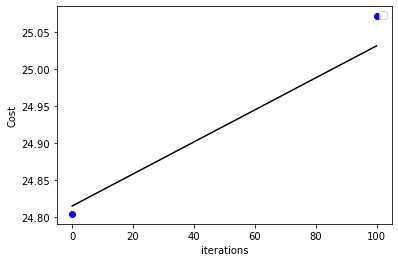

In [65]:
it = np.arange(0,int(iterations/100)+1)

plt.plot(it*100,cost_array_train, color = 'black')
plt.scatter(it*100,cost_array_validation, color = 'blue')
plt.ylabel("Cost")
plt.xlabel("iterations")
plt.legend()

In [71]:
acc,a = Predict(X_train,Y_train,parameters)

sum of AL is [1.         0.99999999 1.         ... 1.         1.         1.        ]


In [72]:
acc

0.21869642857142857

In [60]:
pd.DataFrame(parameters['W2'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.237975,0.008167,-0.372836,0.196120,-0.183504,0.434111,-0.488822,0.452078,-0.560234,0.163456,-0.371660,-0.092976,-0.321391,0.219968,-0.267495,-0.271414,-0.074937,-0.290646,0.329694,-0.213763
1,-0.148441,0.630465,-0.135511,-0.077286,0.212930,-0.607484,0.702503,0.800684,0.062931,1.017036,0.387758,0.108400,-0.226085,-0.529272,0.019381,-0.536065,-0.037735,0.361596,-0.116261,0.338122
2,-0.127389,0.172524,0.390304,0.282888,0.732124,0.577476,0.160080,0.430464,-0.204069,-0.218422,0.088829,-0.737188,-0.363900,-0.280313,-0.030606,-0.266303,0.227253,-0.204013,-0.131200,0.025853
3,0.219899,-0.124378,-0.048462,0.172059,0.459846,0.566336,-0.213754,-0.663842,-0.096213,0.147313,0.362739,0.412665,0.463429,0.617387,0.459023,-0.210563,0.292393,0.502796,0.264828,-0.648630
4,0.023138,-0.459974,-0.094852,0.577314,0.382130,-0.240936,0.544528,-0.241391,-0.129671,0.394482,0.529560,-0.669959,0.147032,0.236594,0.167888,-0.158655,-0.472602,0.392581,0.721358,0.459673
5,-0.118718,0.022657,-0.054367,0.124249,0.232119,-0.564402,-0.312319,-0.072657,-0.236111,0.641208,-0.101095,0.319638,-0.425976,-0.051619,-0.345343,0.053389,0.287743,-0.335347,-0.011797,-0.265535
6,-0.044648,0.088195,-0.045447,-0.008388,0.282878,-0.306269,-0.577847,-0.029311,0.121954,0.009567,0.185532,-0.040022,-0.174968,-0.557409,0.158902,-0.033311,0.037673,-0.256681,0.892976,0.225374
